# Modelo Sin Ranking:
+ GBR

In [242]:
# lectura de archivo y filtros o trasnformaciones
import numpy as np
import pandas as pd

# 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression,Ridge
from sklearn.metrics import (explained_variance_score,
                             mean_absolute_error,
                             mean_squared_error,
                             mean_squared_log_error,
                             median_absolute_error,
                             r2_score)

from sklearn.ensemble.partial_dependence import plot_partial_dependence

# visualizacion de datos
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (16,8)

In [243]:
df = pd.read_pickle('df_4_regresion_clean.pkl').reset_index(drop=True)

In [244]:
df.head()

,jugador,fecha_nacimiento_x,nacionalidad,equipo_x,posicion_1,posicion_2,posicion_3,minutos_jugados_pos1,minutos_jugados_pos2,minutos_jugados_pos3,...,ranking_restringido_pos1,ranking_restringido_pos2,ranking_restringido_pos3,value_2015,value_2016,edad,minutos_totales,ranking_promedio,ranking_restringido_promedio,cociente
0,"Abila, Ramon",1989-10-14,Argentina,Club Atlético Huracán,Delantero,Delantero con Movilidad,No aplica,2094.0,2094.0,0.0,...,2.281160,1.449713,0.0,0.400,0.400,26.0,2094.0,1.865437,1.865437,1.000000
1,"Acevedo, Nelson",1988-07-11,Argentina,Club Atlético Unión (Santa Fe),Volante defensivo,Volante Mixto,No aplica,699.0,699.0,0.0,...,8.114807,6.786695,0.0,0.075,0.225,28.0,699.0,7.450751,7.450751,3.000000
2,"Acosta, Lautaro",1988-03-14,Argentina,Club Atlético Lanús,Volante por izquierda,Volante Mixto,No aplica,1842.0,1842.0,0.0,...,3.784080,3.557492,0.0,1.800,2.000,28.0,1842.0,3.670786,3.670786,1.111111
3,"Acuna, Marcos",1991-10-28,Argentina,Racing Club,Volante por derecha,Volante Mixto,No aplica,1557.0,1557.0,0.0,...,4.772254,5.514451,0.0,0.050,2.000,24.0,1557.0,5.143353,5.143353,40.000000
4,"Acuna, Walter",1992-03-04,Argentina,Club Olimpo,Volante Mixto,Volante ofensivo,No aplica,738.0,738.0,0.0,...,2.763415,2.701220,0.0,0.700,2.000,24.0,738.0,2.732317,2.732317,2.857143


# Quitar ranking y agregar stats para el modelo

In [245]:
xls = pd.ExcelFile('Matrix Liga Argentina J1-J30 2015-2016.xlsx')
sheet_cols = ['Volante izq. ofensivo', 
               'Volante der. ofensivo',
               'Lateral izq. ofensivo',
               'Lateral der. ofensivo',
               'Delantero', '2do Delantero', 'Defensa Central Stopper',
               'Defensa Central Líbero', 'Medio de contención',
               'Volante mixto','"10"']

df_stats = pd.DataFrame() 
for i in sheet_cols:
    df1 = pd.read_excel(xls, sheet_name=i)
    df1 = df1.iloc[:,:-13]
    try:
        df1.drop('Portero',1,inplace=True)
    except KeyError:
        pass
    
    cols = []
    for i in df1.columns:
        if len(i.split("(")) > 1:
            cols.append(i.split(" (")[0].replace("  "," ").replace(" ","_").lower())
        else:
            cols.append(i.replace(" ","_").lower())
    df1.columns = cols
    
    df_stats = pd.concat([df_stats,df1])

/home/serch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [246]:
df_stats = df_stats[['jugador','posicion','equipo','1_vs_1_exitosos_defensivos', '1_vs_1_exitosos_ofensivos',
       'asistencias', 'balones_ganados_en_área_propia',
       'balones_ganados_en_área_rival', 'balones_ganados_en_área_rival_',
       'balones_recuperados', 'centros_por_derecha', 'centros_por_izquierda',
       'goles','juego_aéreo_resto_del_campo',
       'participación_en_gol', 'partidos_jugados',
       'pases_acertados_cancha_propia', 'pases_acertados_en_cancha_rival',
       'rechaces', 'tiros_a_gol']]
df_stats.head()

,jugador,posicion,equipo,1_vs_1_exitosos_defensivos,1_vs_1_exitosos_ofensivos,asistencias,balones_ganados_en_área_propia,balones_ganados_en_área_rival,balones_ganados_en_área_rival_,balones_recuperados,centros_por_derecha,centros_por_izquierda,goles,juego_aéreo_resto_del_campo,participación_en_gol,partidos_jugados,pases_acertados_cancha_propia,pases_acertados_en_cancha_rival,rechaces,tiros_a_gol
0,"Acosta, Lautaro",Volante por izquierda,Lanus,1.0,89,2.0,1.0,11.0,NaN,29.0,0.0,28.0,5.0,14.0,2.0,24,36.0,280,31.0,20.0
1,"Aguirre, Jonas",Volante por izquierda,Rosario Central,5.0,55,3.0,3.0,18.0,NaN,34.0,11.0,74.0,0.0,38.0,4.0,22,70.0,221,44.0,29.0
2,"Alanis, Gabriel",Volante por izquierda,Belgrano,8.0,3,0.0,3.0,19.0,NaN,73.0,11.0,3.0,0.0,35.0,0.0,5,180.0,14,60.0,0.0
3,"Alaniz, Diego",Volante por izquierda,Argentinos Juniors,15.0,4,0.0,13.0,11.0,NaN,138.0,7.0,5.0,0.0,69.0,0.0,6,212.0,39,100.0,2.0
4,"Andrada, Omar Brian",Volante por izquierda,Gimnasia La Plata,1.0,0,0.0,0.0,4.0,NaN,17.0,8.0,0.0,0.0,0.0,0.0,1,52.0,2,6.0,0.0


Existen duplicados en la base de ranking

In [247]:
df_stats.drop_duplicates(subset=['jugador','posicion','equipo'], inplace=True)

__Existen jugadores que tienen mas de un equipo y una posicion durante la temporada, se quedara con el primer registro que encuentre agrupando por jugador y posicion__

In [248]:
df_stats.shape

(894, 20)

In [249]:
df_stats[df_stats.jugador == 'Yeri, Nahuel']

,jugador,posicion,equipo,1_vs_1_exitosos_defensivos,1_vs_1_exitosos_ofensivos,asistencias,balones_ganados_en_área_propia,balones_ganados_en_área_rival,balones_ganados_en_área_rival_,balones_recuperados,centros_por_derecha,centros_por_izquierda,goles,juego_aéreo_resto_del_campo,participación_en_gol,partidos_jugados,pases_acertados_cancha_propia,pases_acertados_en_cancha_rival,rechaces,tiros_a_gol
90,"Yeri, Nahuel",Volante por derecha,Aldosivi,9.0,9,0.0,11.0,7.0,NaN,87.0,16.0,2.0,0.0,NaN,0.0,17,134.0,172,115.0,9.0
65,"Yeri, Nahuel",Lateral por derecha,Banfield,NaN,17,1.0,NaN,NaN,NaN,NaN,27.0,NaN,0.0,NaN,5.0,22,NaN,245,NaN,21.0


In [250]:
df_stats_grouped = df_stats.groupby(['jugador']).first()

In [251]:
df = df.merge(df_stats_grouped, on='jugador').drop(['ranking_pos1',
       'ranking_pos2', 'ranking_pos3', 'ranking_restringido_pos1',
       'ranking_restringido_pos2', 'ranking_restringido_pos3','ranking_promedio','ranking_restringido_promedio','balones_ganados_en_área_rival_'],1)

In [252]:
df.shape

(499, 33)

In [253]:
df.columns

Index(['jugador', 'fecha_nacimiento_x', 'nacionalidad', 'equipo_x',
       'posicion_1', 'posicion_2', 'posicion_3', 'minutos_jugados_pos1',
       'minutos_jugados_pos2', 'minutos_jugados_pos3', 'value_2015',
       'value_2016', 'edad', 'minutos_totales', 'cociente', 'posicion',
       'equipo', '1_vs_1_exitosos_defensivos', '1_vs_1_exitosos_ofensivos',
       'asistencias', 'balones_ganados_en_área_propia',
       'balones_ganados_en_área_rival', 'balones_recuperados',
       'centros_por_derecha', 'centros_por_izquierda', 'goles',
       'juego_aéreo_resto_del_campo', 'participación_en_gol',
       'partidos_jugados', 'pases_acertados_cancha_propia',
       'pases_acertados_en_cancha_rival', 'rechaces', 'tiros_a_gol'],
      dtype='object')

In [254]:
df.drop_duplicates(subset=['jugador', 'fecha_nacimiento_x', 'nacionalidad',
       'posicion_1', 'posicion_2', 'posicion_3'], inplace=True)

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 497
Data columns (total 33 columns):
jugador                            418 non-null object
fecha_nacimiento_x                 418 non-null datetime64[ns]
nacionalidad                       418 non-null object
equipo_x                           418 non-null object
posicion_1                         418 non-null object
posicion_2                         418 non-null object
posicion_3                         418 non-null object
minutos_jugados_pos1               418 non-null float64
minutos_jugados_pos2               418 non-null float64
minutos_jugados_pos3               418 non-null float64
value_2015                         418 non-null float64
value_2016                         418 non-null float64
edad                               418 non-null float64
minutos_totales                    418 non-null float64
cociente                           418 non-null float64
posicion                           418 non-null object

In [256]:
df[df.jugador == 'Zuqui, Fernando']

,jugador,fecha_nacimiento_x,nacionalidad,equipo_x,posicion_1,posicion_2,posicion_3,minutos_jugados_pos1,minutos_jugados_pos2,minutos_jugados_pos3,...,centros_por_derecha,centros_por_izquierda,goles,juego_aéreo_resto_del_campo,participación_en_gol,partidos_jugados,pases_acertados_cancha_propia,pases_acertados_en_cancha_rival,rechaces,tiros_a_gol
495,"Zuqui, Fernando",1991-11-27,Argentina,Club Atlético Boca Juniors,Volante por derecha,Volante defensivo,Volante Mixto,432.0,2466.0,2466.0,...,5.0,0.0,0.0,64.0,1.0,13,60.0,121,20.0,6.0


In [257]:
df.fillna(0,inplace=True)

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 497
Data columns (total 33 columns):
jugador                            418 non-null object
fecha_nacimiento_x                 418 non-null datetime64[ns]
nacionalidad                       418 non-null object
equipo_x                           418 non-null object
posicion_1                         418 non-null object
posicion_2                         418 non-null object
posicion_3                         418 non-null object
minutos_jugados_pos1               418 non-null float64
minutos_jugados_pos2               418 non-null float64
minutos_jugados_pos3               418 non-null float64
value_2015                         418 non-null float64
value_2016                         418 non-null float64
edad                               418 non-null float64
minutos_totales                    418 non-null float64
cociente                           418 non-null float64
posicion                           418 non-null object

In [259]:
df.columns

Index(['jugador', 'fecha_nacimiento_x', 'nacionalidad', 'equipo_x',
       'posicion_1', 'posicion_2', 'posicion_3', 'minutos_jugados_pos1',
       'minutos_jugados_pos2', 'minutos_jugados_pos3', 'value_2015',
       'value_2016', 'edad', 'minutos_totales', 'cociente', 'posicion',
       'equipo', '1_vs_1_exitosos_defensivos', '1_vs_1_exitosos_ofensivos',
       'asistencias', 'balones_ganados_en_área_propia',
       'balones_ganados_en_área_rival', 'balones_recuperados',
       'centros_por_derecha', 'centros_por_izquierda', 'goles',
       'juego_aéreo_resto_del_campo', 'participación_en_gol',
       'partidos_jugados', 'pases_acertados_cancha_propia',
       'pases_acertados_en_cancha_rival', 'rechaces', 'tiros_a_gol'],
      dtype='object')

In [260]:
cols_cat = ['nacionalidad','equipo_x','posicion_1','posicion_2','posicion_3']

In [261]:
# se generan dos dataframes una quitando una variable dummi de cada categoria.
df_dummi_first_drop = pd.get_dummies(df,columns=cols_cat)

In [262]:
# variables nuevas
df_dummi_first_drop['efectividad_a_gol'] = np.where(df_dummi_first_drop.tiros_a_gol != 0,
                                                    df_dummi_first_drop.goles / df_dummi_first_drop.tiros_a_gol, 0)
df_dummi_first_drop['efectividad_asistida'] = np.where(df_dummi_first_drop.participación_en_gol != 0,
                                                       df_dummi_first_drop.asistencias / df_dummi_first_drop.participación_en_gol, 0)
df_dummi_first_drop['efectividad_de_juego'] = np.where(df_dummi_first_drop.partidos_jugados != 0,
                                                       df_dummi_first_drop.minutos_totales / df_dummi_first_drop.partidos_jugados, 0)

df_dummi_first_drop['centros_totales'] = df_dummi_first_drop['centros_por_derecha'] + df_dummi_first_drop['centros_por_izquierda']
df_dummi_first_drop['pases_totales'] = df_dummi_first_drop['pases_acertados_cancha_propia']+df_dummi_first_drop['pases_acertados_en_cancha_rival']
df_dummi_first_drop['regates_totales'] = df_dummi_first_drop['1_vs_1_exitosos_defensivos']+df_dummi_first_drop['1_vs_1_exitosos_ofensivos']

#oscar vars
df_dummi_first_drop['promedio_de_goles_por_partido'] = np.where(df_dummi_first_drop.partidos_jugados != 0,
                                                       df_dummi_first_drop.goles / df_dummi_first_drop.partidos_jugados, 0)
df_dummi_first_drop['promedio_de_centros_por_partido'] = np.where(df_dummi_first_drop.partidos_jugados != 0,
                                                       df_dummi_first_drop.centros_totales / df_dummi_first_drop.partidos_jugados, 0)
df_dummi_first_drop['promedio_de_pases_por_partido'] = np.where(df_dummi_first_drop.partidos_jugados != 0,
                                                       df_dummi_first_drop.pases_totales / df_dummi_first_drop.partidos_jugados, 0)
df_dummi_first_drop['promedio_de_regates_por_partido'] = np.where(df_dummi_first_drop.partidos_jugados != 0,
                                                       df_dummi_first_drop.regates_totales / df_dummi_first_drop.partidos_jugados, 0)

#var_diegou
df_dummi_first_drop['minutostotales_entre_edad'] = df_dummi_first_drop.minutos_totales/df_dummi_first_drop.edad

In [265]:
df_dummi_first_drop.columns

Index(['jugador', 'fecha_nacimiento_x', 'minutos_jugados_pos1',
       'minutos_jugados_pos2', 'minutos_jugados_pos3', 'value_2015',
       'value_2016', 'edad', 'minutos_totales', 'cociente', 'posicion',
       'equipo', '1_vs_1_exitosos_defensivos', '1_vs_1_exitosos_ofensivos',
       'asistencias', 'balones_ganados_en_área_propia',
       'balones_ganados_en_área_rival', 'balones_recuperados',
       'centros_por_derecha', 'centros_por_izquierda', 'goles',
       'juego_aéreo_resto_del_campo', 'participación_en_gol',
       'partidos_jugados', 'pases_acertados_cancha_propia',
       'pases_acertados_en_cancha_rival', 'rechaces', 'tiros_a_gol',
       'nacionalidad_Argentina', 'nacionalidad_Chilena',
       'nacionalidad_Colombiana', 'nacionalidad_Ecuatoriana',
       'nacionalidad_Paraguaya', 'nacionalidad_Uruguaya',
       'equipo_x_Arsenal Fútbol Club',
       'equipo_x_Asociación Atlética Argentinos Juniors',
       'equipo_x_Atlético de Rafaela', 'equipo_x_Club Atlético Aldosivi

In [266]:
x_reg = ['minutos_jugados_pos1',
       'minutos_jugados_pos2', 'minutos_jugados_pos3', 'value_2015',
       'edad', 'minutos_totales',
       '1_vs_1_exitosos_defensivos', '1_vs_1_exitosos_ofensivos',
       'asistencias', 'balones_ganados_en_área_propia',
       'balones_ganados_en_área_rival', 'balones_recuperados',
       'centros_por_derecha', 'centros_por_izquierda', 'goles',
       'juego_aéreo_resto_del_campo', 'participación_en_gol',
       'partidos_jugados', 'pases_acertados_cancha_propia',
       'pases_acertados_en_cancha_rival', 'rechaces', 'tiros_a_gol',
       'nacionalidad_Argentina', 'nacionalidad_Chilena',
       'nacionalidad_Colombiana', 'nacionalidad_Ecuatoriana',
       'nacionalidad_Paraguaya', 'nacionalidad_Uruguaya',
       'equipo_x_Arsenal Fútbol Club',
       'equipo_x_Asociación Atlética Argentinos Juniors',
       'equipo_x_Atlético de Rafaela', 'equipo_x_Club Atlético Aldosivi',
       'equipo_x_Club Atlético Banfield', 'equipo_x_Club Atlético Belgrano',
       'equipo_x_Club Atlético Boca Juniors', 'equipo_x_Club Atlético Colón',
       'equipo_x_Club Atlético Huracán',
       'equipo_x_Club Atlético Independiente', 'equipo_x_Club Atlético Lanús',
       "equipo_x_Club Atlético Newell's Old Boys",
       'equipo_x_Club Atlético Patronato',
       'equipo_x_Club Atlético River Plate',
       'equipo_x_Club Atlético Rosario Central',
       'equipo_x_Club Atlético San Lorenzo de Almagro',
       'equipo_x_Club Atlético San Martín (SJ)',
       'equipo_x_Club Atlético Sarmiento (Junin)',
       'equipo_x_Club Atlético Temperley', 'equipo_x_Club Atlético Tigre',
       'equipo_x_Club Atlético Tucumán',
       'equipo_x_Club Atlético Unión (Santa Fe)',
       'equipo_x_Club Atlético Vélez Sarsfield',
       'equipo_x_Club Deportivo Godoy Cruz Antonio Tomba',
       'equipo_x_Club Estudiantes de La Plata', 'equipo_x_Club Olimpo',
       'equipo_x_Club de Gimnasia y Esgrima La Plata',
       'equipo_x_Defensa y Justicia', 'equipo_x_Quilmes Atlético Club',
       'equipo_x_Racing Club', 'posicion_1_Defensa central',
       'posicion_1_Delantero', 'posicion_1_Lateral por derecha',
       'posicion_1_Lateral por izquierda', 'posicion_1_Volante Mixto ',
       'posicion_1_Volante defensivo', 'posicion_1_Volante por derecha',
       'posicion_1_Volante por izquierda', 'posicion_2_Defensa central',
       'posicion_2_Delantero con Movilidad', 'posicion_2_Lateral por derecha',
       'posicion_2_Lateral por izquierda', 'posicion_2_No aplica',
       'posicion_2_Volante Mixto ', 'posicion_2_Volante defensivo',
       'posicion_2_Volante ofensivo', 'posicion_3_No aplica',
       'posicion_3_Volante Mixto ', 'posicion_3_Volante ofensivo',
       'efectividad_a_gol', 'efectividad_asistida', 'efectividad_de_juego',
       'centros_totales', 'pases_totales', 'regates_totales',
       'promedio_de_goles_por_partido', 'promedio_de_centros_por_partido',
       'promedio_de_pases_por_partido', 'promedio_de_regates_por_partido',
        'minutostotales_entre_edad']

y = 'value_2016'

In [267]:
x_train_test,x_valid, y_train_test,y_valid = train_test_split(
    df_dummi_first_drop[x_reg], df_dummi_first_drop[y], test_size=0.1, random_state = 8)

x_train,x_test, y_train,y_test = train_test_split(
    x_train_test, y_train_test, test_size=0.1, random_state = 8)

In [268]:
#Tamaño grid depth
ND = 3
min_depth = 3
max_depth = 5
grid_depth =  np.linspace(min_depth,max_depth,ND).astype('int')
# tamaño grid ntrees
NT = 10
min_trees = 90
max_trees = 300
grid_tree = np.linspace(min_trees, max_trees, NT).astype('int')

mse_error = np.zeros((ND,NT))

for i, max_depth in enumerate(grid_depth):
    for j,ntrees in enumerate(grid_tree):
        clf = GradientBoostingRegressor(n_estimators= ntrees, 
                                        max_depth = max_depth,random_state=8)

# hacer unestimación sobre train
        clf.fit(x_train, y_train)
    # hagamos un predict: test
        rmse_test = np.sqrt(mean_squared_error(y_test, clf.predict(x_test)))
    # y guardemos
        mse_error[i,j] = rmse_test


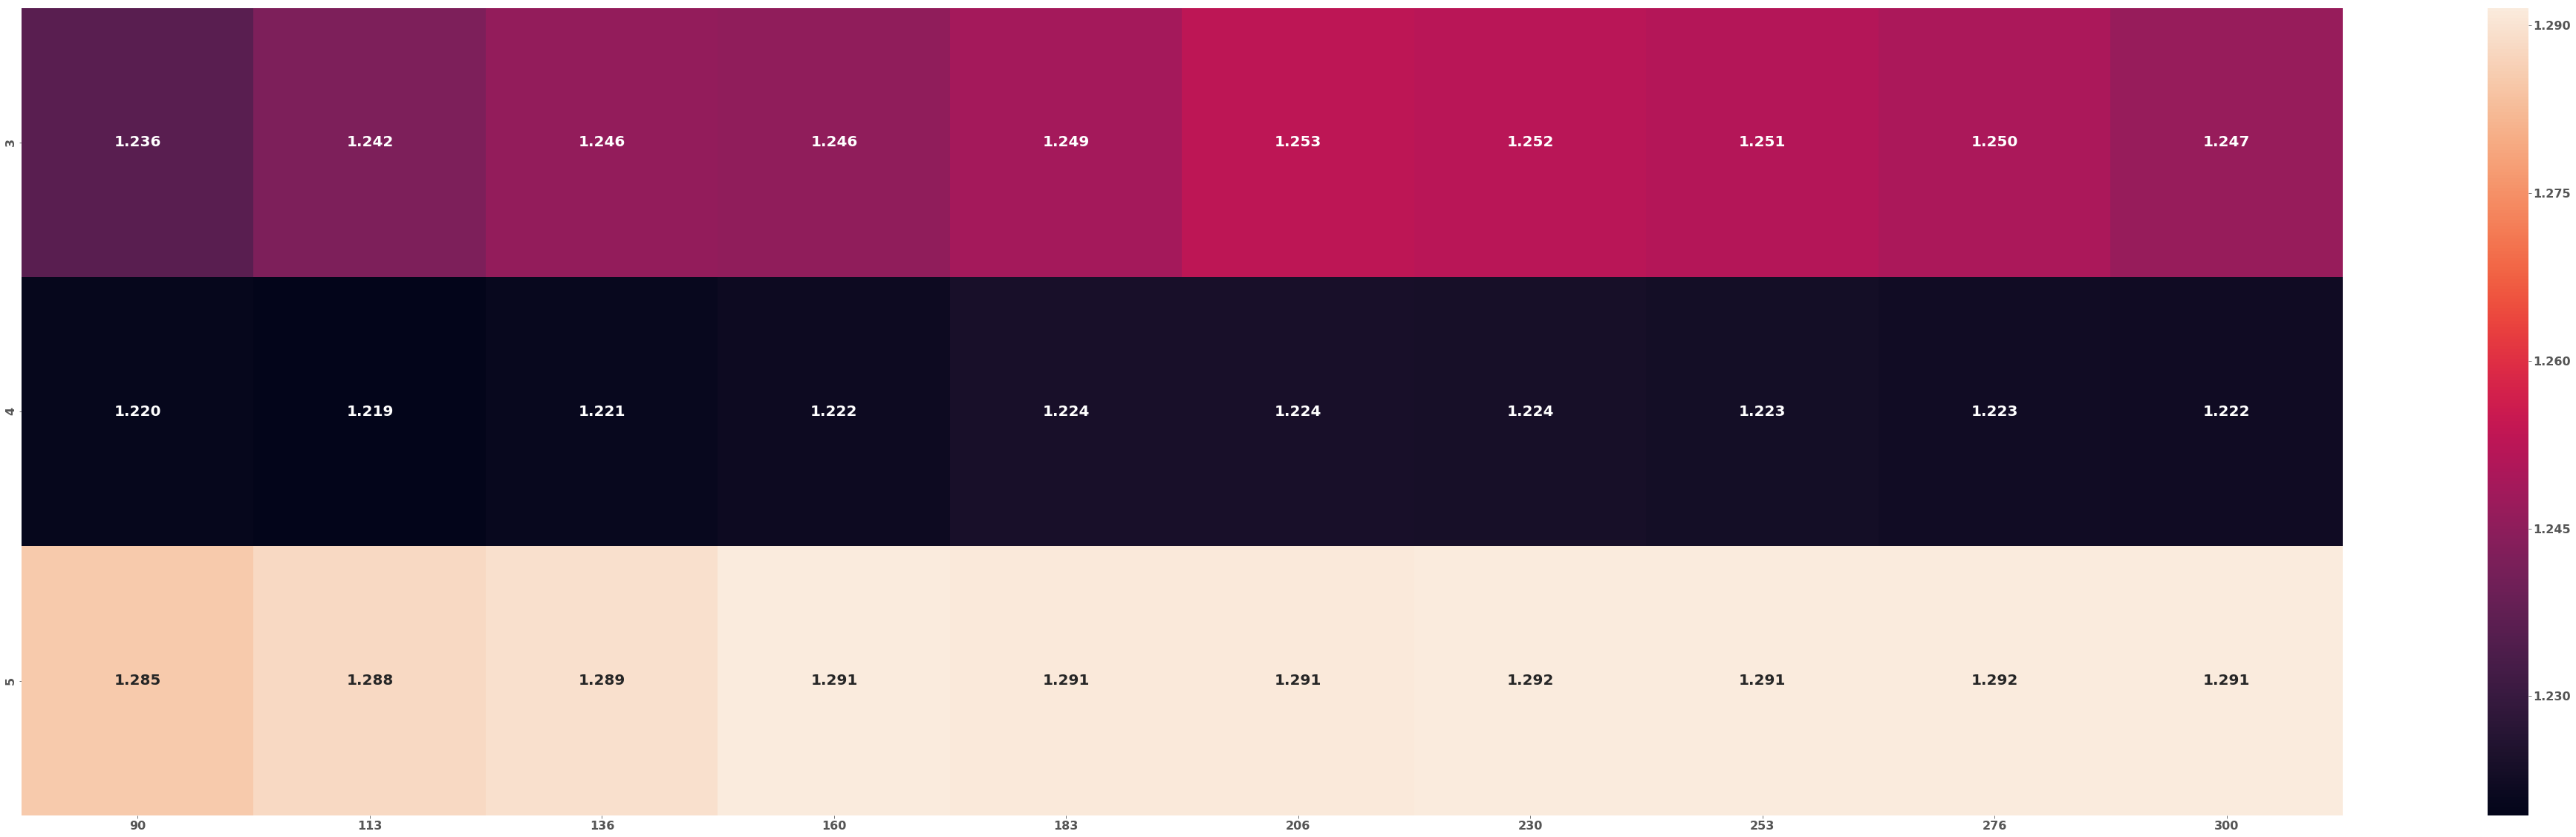

In [269]:
df_error = pd.DataFrame(
    mse_error,columns=grid_tree,index=grid_depth)
plt.figure(figsize=(70,20))
sns.heatmap(df_error,
            annot=True,fmt='.3f')

In [272]:
gs_gbc = GradientBoostingRegressor(n_estimators= 113, max_depth = 4,random_state=8)
# hacer unestimación sobre train
gs_gbc.fit(x_train, y_train)

y_pred = gs_gbc.predict(x_test)

In [274]:
print("====",'TEST','====')
y_pred = gs_gbc.predict(x_test)

print('RMSE',np.sqrt(mean_squared_error(y_test,y_pred)))
res = abs(y_test - y_pred)/y_test
print('epp',res.mean()*100)
print('r_2',r2_score(y_test,y_pred))

print("====",'VALID','====')
y_pred = gs_gbc.predict(x_valid)

print('RMSE',np.sqrt(mean_squared_error(y_valid,y_pred)))
res = abs(y_valid - y_pred)/y_valid
print('epp',res.mean()*100)
print('r_2',r2_score(y_valid,y_pred));

==== TEST ====
RMSE 1.2193458004905968
epp 78.23507568383668
r_2 0.302958670112082
==== VALID ====
RMSE 0.527130162106963
epp 55.63934364713169
r_2 0.7721444653075589


# Interpretacion variables

Text(0.5, 0, 'Importancia relativa')

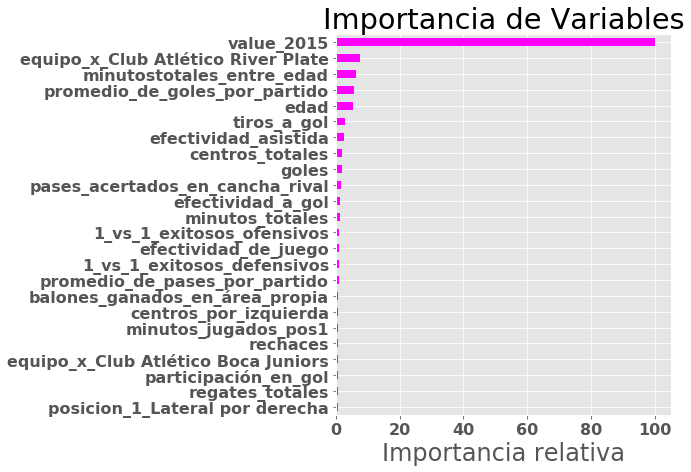

In [275]:
#DF de variables mas importantes
f_imp = pd.DataFrame(gs_gbc.feature_importances_,
                     index=x_train.columns, columns=['imp'])
#calculo de importancia relativa
f_imp['imp_rel'] = (f_imp/f_imp.max()*100)
#plot de importancia de variables
f_imp[f_imp.imp_rel > 0.5].sort_values('imp_rel',ascending=True).imp_rel.plot.barh(figsize=(6,7),
                                                              title='Importancia de Variables',color='magenta')
plt.xlabel('Importancia relativa')

In [276]:
a = pd.DataFrame(gs_gbc.feature_importances_,index=x_valid.columns,
             columns=['imp']).sort_values('imp')

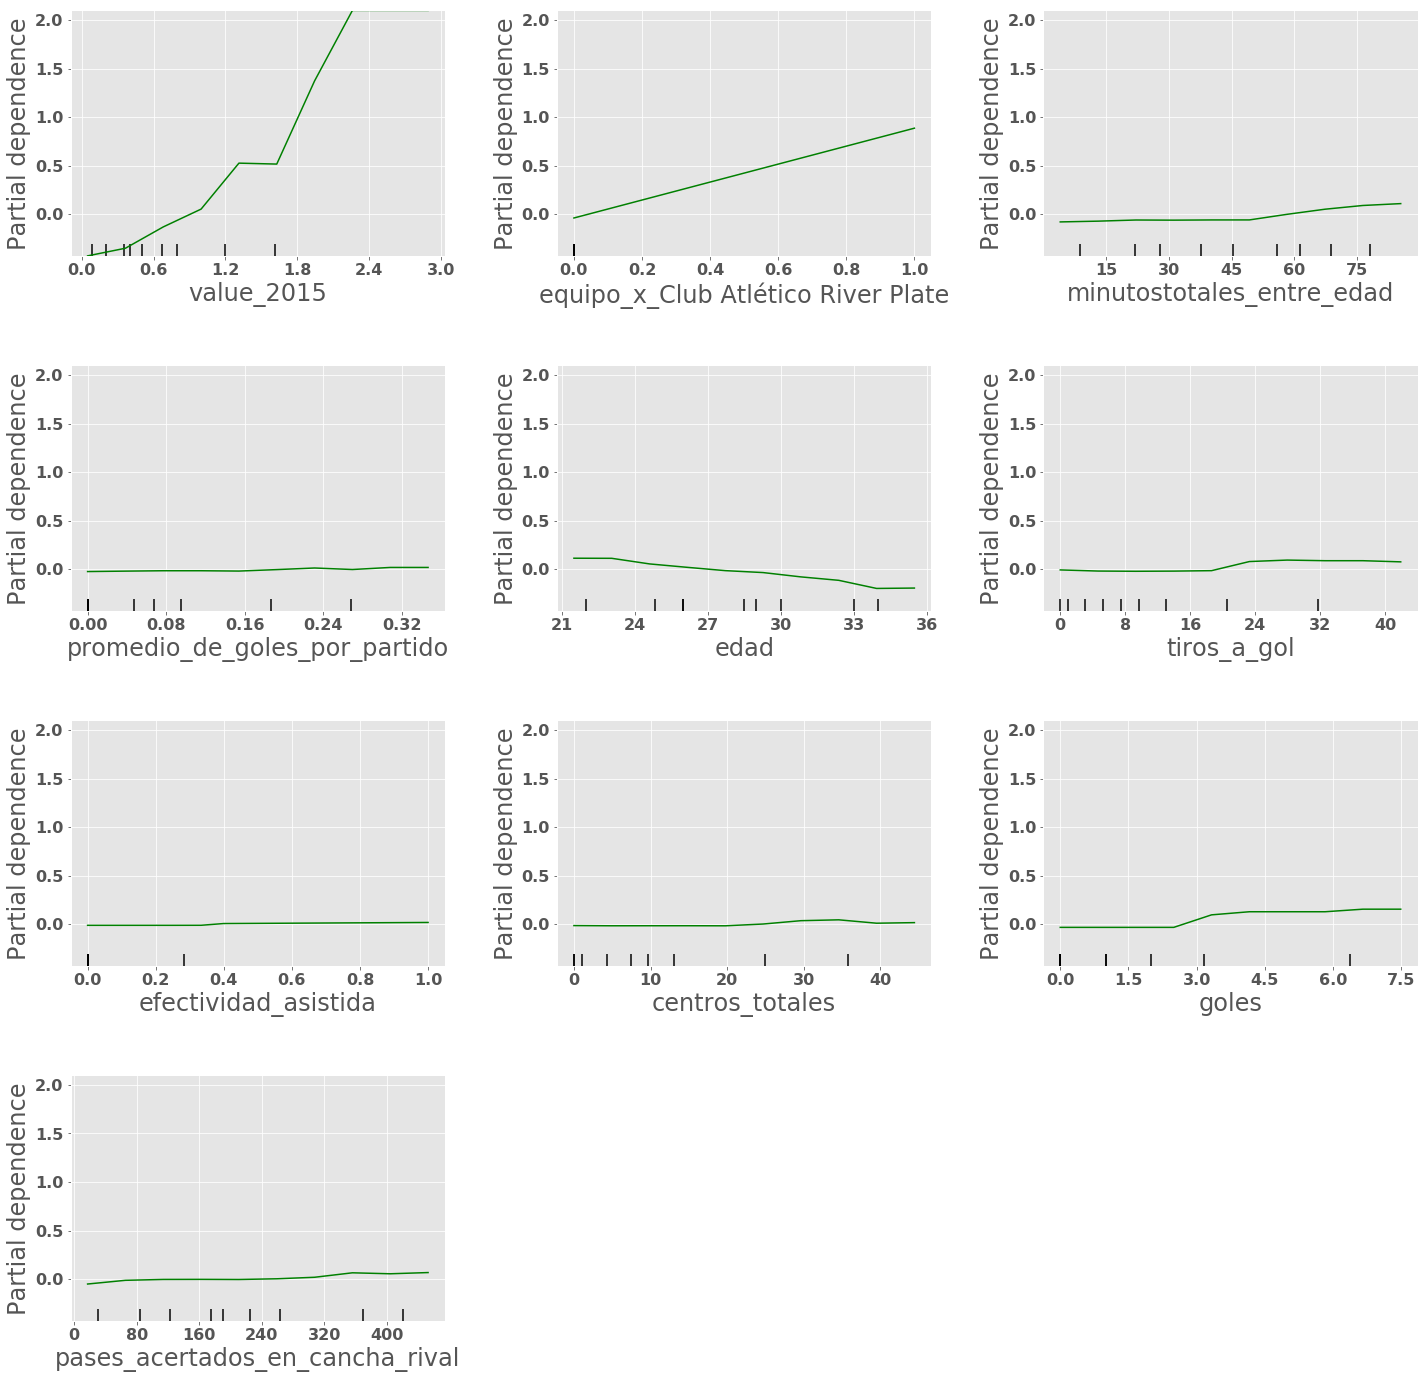

In [280]:
names = list(a.tail(10).index)
feat = []
lista_casv = list(x_valid.columns)

for i in a.tail(10).index:
    if i in lista_casv:
        feat.append(lista_casv.index(i))
        
plot_partial_dependence(gs_gbc,x_valid,reversed(feat), feature_names=x_valid.columns,
                        grid_resolution=10,figsize=(20,20))

plt.tight_layout()

In [281]:
top5_vars = pd.DataFrame(gs_gbc.feature_importances_, index = x_train.columns, columns = ['feat_imp']
            ).sort_values(by='feat_imp', ascending=False).index[:10]

num_top5 = np.arange(x_train.shape[1])[np.in1d(x_train.columns, top5_vars)]


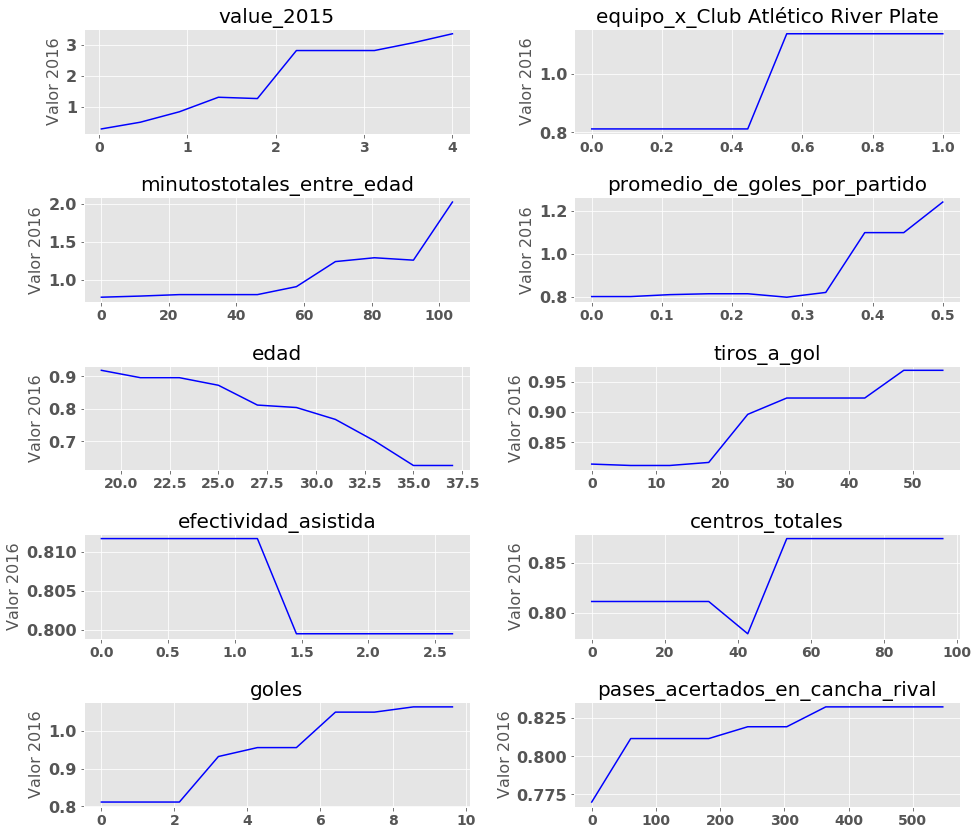

In [282]:
mean_x = pd.DataFrame(np.tile(x_train.mean().values.reshape((1,x_train.shape[1])), (10,1)),
                     columns = x_train.columns)

plt.figure(figsize=(14,12))
for i in range(10):
    
    # grid
    grid_x = np.linspace(x_train[top5_vars[i]].min(), 
                     x_train[top5_vars[i]].quantile(0.99), 10)
    # Manual
    x_simu = mean_x.copy()
    # remplazos columna correspondiente por grid
    x_simu[top5_vars[i]] = grid_x.reshape((10))
    plt.subplot(5,2,i+1)
    # manual
    y_simu = gs_gbc.predict(x_simu)
    y_simu_std = (y_simu-y_simu.mean())
    plt.plot(grid_x, y_simu, color='b')
    
    plt.title(top5_vars[i], fontsize = 20)
#     plt.xlabel(u'Días sin recarga / Promedio de días entre recarga', fontsize=10)
    plt.ylabel(u'Valor 2016', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=16)
    
plt.tight_layout()